# Using Trotterization to solve the time-dependent Schrödinger equation on the superconducting backends of Quantum Inspire

**Author:** Marios Samiotis (m.samiotis@tudelft.nl)

**Date:** December 19, 2025

# 1. Introduction

In this notebook, we will explore the simulation of the time-dependent Schrödinger equation for a simple 2-spin system using one of the superconducting backends available on the Quantum Inspire 2.0 platform.

Prior to using this notebook, for optimal performance, make sure that you are running it within a customized Python 3.12 environment which includes the packages "quantuminspire" and "qiskit-quantuminspire" [(installation instructions)](https://github.com/DiCarloLab-Delft/QuantumInspireUtilities/blob/main/README.md).

This is an advanced tutorial intended for users who are already familiar with using the superconducting backends of Quantum Inspire for their own experiments. If you are a beginner, we highly recommend going through the Getting Started guide for the [Tuna backends](https://github.com/DiCarloLab-Delft/QuantumInspireUtilities/blob/main/qi_utilities/notebook_guides/0.1_getting_started_tuna_devices.ipynb) before continuing with this notebook.

Useful links:
1. [Tuna Backends Operational Specifics](https://www.quantum-inspire.com/kbase/tuna-operational-specifics/)
2. [Backend Performance Dashboards](https://monitoring.qutech.support/public-dashboards/c494a21fb6b7405f850ab8f340f798ef?orgId=1&refresh=10s) [live updates]
3. [Join our Slack community!](https://join.slack.com/t/qisuperconducting/shared_invite/zt-35o7zitdh-_9QPmB53hhLy12Eat5gwWA)

First, we run the following cell in order to login to the Quantum Inspire platform. You need an account in order to login to the platform.

Please click on "Confirm" in the pop-up browser window to login.

In [1]:
! qi login "https://api.quantum-inspire.com"

Please continue logging in by opening: https://auth.quantum-inspire.com/activate?user_code=BMNW-VQPH in your browser
If promped to verify a code, please confirm it is as follows: BMNW-VQPH
Login successful!
Using member ID 10


Run the following cell for all necessary library imports,

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile
import qiskit.quantum_info as qi
from qiskit_quantuminspire.qi_provider import QIProvider

from qi_utilities.utility_functions.circuit_modifiers import apply_readout_circuit
from qi_utilities.algorithms.trotterization import construct_trotterization_circuit
from qi_utilities.classical_solvers.time_evolution import simulate_time_evolution

from qi_utilities.utility_functions.raw_data_processing import (get_raw_data, get_multi_counts, get_multi_probs,
                                                                observable_expectation_values_Z_basis)
from qi_utilities.utility_functions.readout_correction import (split_raw_shots, extract_ro_assignment_matrix, plot_ro_assignment_matrix,
                                                               get_ro_corrected_multi_probs)
from qi_utilities.utility_functions.data_handling import StoreProjectRecord

# 2. Connecting to a Quantum Inspire backend

We first connect to the Quantum Inspire provider, by running the following cell,

In [3]:
provider = QIProvider()

The following command prints the full list of all available backends of the platform,

In [4]:
provider.backends()

[<qiskit_quantuminspire.qi_backend.QIBackend object at 0x114c9f5f0 (name=QX emulator, id=1)>,
 <qiskit_quantuminspire.qi_backend.QIBackend object at 0x10e7413d0 (name=Ry emulator, id=5)>,
 <qiskit_quantuminspire.qi_backend.QIBackend object at 0x112febdd0 (name=Tuna-9, id=6)>]

Connect to any of the superconducting backends by running the following cell,

In [5]:
backend_name = "Tuna-9" # check availability!
backend = provider.get_backend(name=backend_name)

By running the cell below, the connectivity of the processor is shown (otherwise known as "coupling map"),

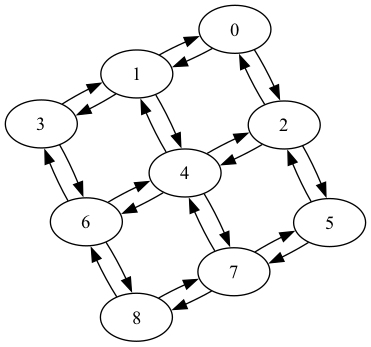

In [6]:
backend.coupling_map.draw()

# 3. Trotterization in a nutshell

For any closed quantum system, the state of the system is described by the state vector $| \psi \rangle$, and the dynamical evolution in time $t$ of the system under the influence of a [Hamiltonian](https://en.wikipedia.org/wiki/Hamiltonian_(quantum_mechanics)) $\hat{H}$ is governed by the [Schrödinger equation]((https://en.wikipedia.org/wiki/Schr%C3%B6dinger_equation)),

$$i \hbar |\psi(t) \rangle = \hat{H} |\psi(t)\rangle.$$

When concerned with the Schrödinger equation, we distinguish between the solutions $|\psi_{i}\rangle$ and the corresponding allowed energies $E_{i}$ of the eigenvalue problem (Eq. 1), and the general time-dependent solution $|\psi(t)\rangle$ (Eq. 2) for an initial state of the system $|\psi(0) \rangle$,

$$\hat{H}|\psi_{i}\rangle = E_{i}|\psi_{i}\rangle \text{ (1), eigenvalue problem}$$
$$|\psi(t) \rangle = \exp(-i\hat{H}t/\hbar)|\psi(0)\rangle \text{ (2), general solution}$$

We wish to simulate the time evolution of an initial quantum state $|\psi(0)\rangle$ of two spins, under the influence of the [Heisenberg (anti)ferromagnetic Hamiltonian](https://en.wikipedia.org/wiki/Quantum_Heisenberg_model) with no external magnetic field applied, where

$$ \hat{H} = \hbar J \left( \hat{X}\hat{X} + \hat{Y}\hat{Y} + \hat{Z}\hat{Z} \right)\text{ (3)}. $$

We distinguish between two cases:

$$\text{1. }J<0, \text{ ferromagnetic interaction}$$
$$\text{2. }J>0, \text{ antiferromagnetic interaction}$$

<div style="text-align: center;">
  <img src="figures/1.0_figure_1.gif" width="700">
</div>

Here we will study the case of the antiferromagnetic interaction between two opposite spins. We note here that the interaction strength $J$ defined above is in S.I. units of [Hz].

We use the mapping convention for the spin-up and spin-down states of a spin $|\uparrow\text{}\rangle\longleftrightarrow |0\rangle$ and $|\downarrow\text{} \rangle \longleftrightarrow |1\rangle$ to the qubit computational states respectively. Therefore, for an initial state of two anti-aligned spins, $|\psi(0)\rangle = |01\rangle$ (in this tutorial we will be using qubits Q0 and Q2). Due to the nature of the interaction, as is described in Eq. (3) for $J>0$, we expect the two spins to evolve in opposite directions to each other in time, transitioning smoothly from the state $|01\rangle$ to $|10\rangle$ and back to $|01\rangle$, with a revolution frequency proportional to $J$.

Inserting Eq. (3) into Eq. (2), we obtain

$$|\psi(t) \rangle = \exp(-i(\hat{X}\hat{X} + \hat{Y}\hat{Y} + \hat{Z}\hat{Z})Jt)|01\rangle \text{ (4)}.$$

Using the [Trotter-Suzuki decomposition](https://en.wikipedia.org/wiki/Hamiltonian_simulation#Product_formulas),

$$ \exp(-i(\hat{X}\hat{X} + \hat{Y}\hat{Y} + \hat{Z}\hat{Z})Jt) \approx \left( \exp(-i\hat{X}\hat{X}Jt/n) \exp(-i\hat{Y}\hat{Y}Jt/n) \exp(-i\hat{Z}\hat{Z}Jt/n) \right)^{n} \text{ (5)},$$

where $n$ is called the Trotter step.

Each of the exponentials in Eq. (5) is a two-qubit unitary gate, and in the half-angle rotation they can be expressed as

$$ R_{XX} \left(\frac{2Jt}{n} \right) = \exp(-i\hat{X}\hat{X}Jt/n)\text{, }R_{YY} \left(\frac{2Jt}{n} \right) = \exp(-i\hat{Y}\hat{Y}Jt/n)\text{, }R_{ZZ} \left(\frac{2Jt}{n} \right) = \exp(-i\hat{Z}\hat{Z}Jt/n),$$

and so Eq. (4) becomes

$$ |\psi(t) \rangle \approx \left( R_{XX} \left(\frac{2Jt}{n} \right) R_{YY} \left(\frac{2Jt}{n} \right) R_{ZZ} \left(\frac{2Jt}{n} \right) \right)^{n} |01\rangle,$$

which at the limit of large $n$ becomes an equality.

For devices where error correction is not applicable, there is always a trade-off that we need to consider; as we increase the Trotter step size $n$, the accuracy of the simulation increases, but at the cost of larger circuit depths which are detrimental to the overall performance of the algorithm on a noisy device. In this guide notebook we will be using the step size $n=1$, and ultimately we will be executing the simpler circuit

$$ |\psi(t) \rangle \approx R_{XX}(2Jt) R_{YY}(2Jt) R_{ZZ} (2Jt) |01\rangle\text{ (6)}.$$

# 4. Constructing the Trotterization circuits

## 4.1. Defining the problem Hamiltonian

In [7]:
nr_qubits = 2
J = 10e6 # in units of [Hz]

In [8]:
pauli_terms = ['XX', 'YY', 'ZZ']
pauli_coefficients = [J, J, J]

hamiltonian_operator = qi.SparsePauliOp(pauli_terms, pauli_coefficients)
print(hamiltonian_operator)

SparsePauliOp(['XX', 'YY', 'ZZ'],
              coeffs=[10000000.+0.j, 10000000.+0.j, 10000000.+0.j])


## 4.2. Defining the simulation parameters and circuits

In [9]:
trotter_order = 1
evolution_times = np.linspace(0.0, 0.5 * np.pi / J, 27)
initial_state = '01'
measured_observable = 'ZZ'

# 5. [SOLUTION METHOD 1] Compiling all circuits into a single job (slower than method 2, see Section 6)

## 5.1. Constructing separately all required circuits and grouping them into one job

In [10]:
qc_list = []

for time_step in range(len(evolution_times)):
    qc = QuantumCircuit(nr_qubits, nr_qubits,
                        name=f"Trotterization_{measured_observable}_Timestep_{time_step}")
    qc_step = construct_trotterization_circuit(initial_state,
                                               measured_observable,
                                               hamiltonian_operator,
                                               trotter_order,
                                               evolution_times,
                                               time_step=time_step)
    qc = qc.compose(qc_step)
    qc_list.append(qc)

qc_list[0] = apply_readout_circuit(qc_list[0], list(range(nr_qubits)))

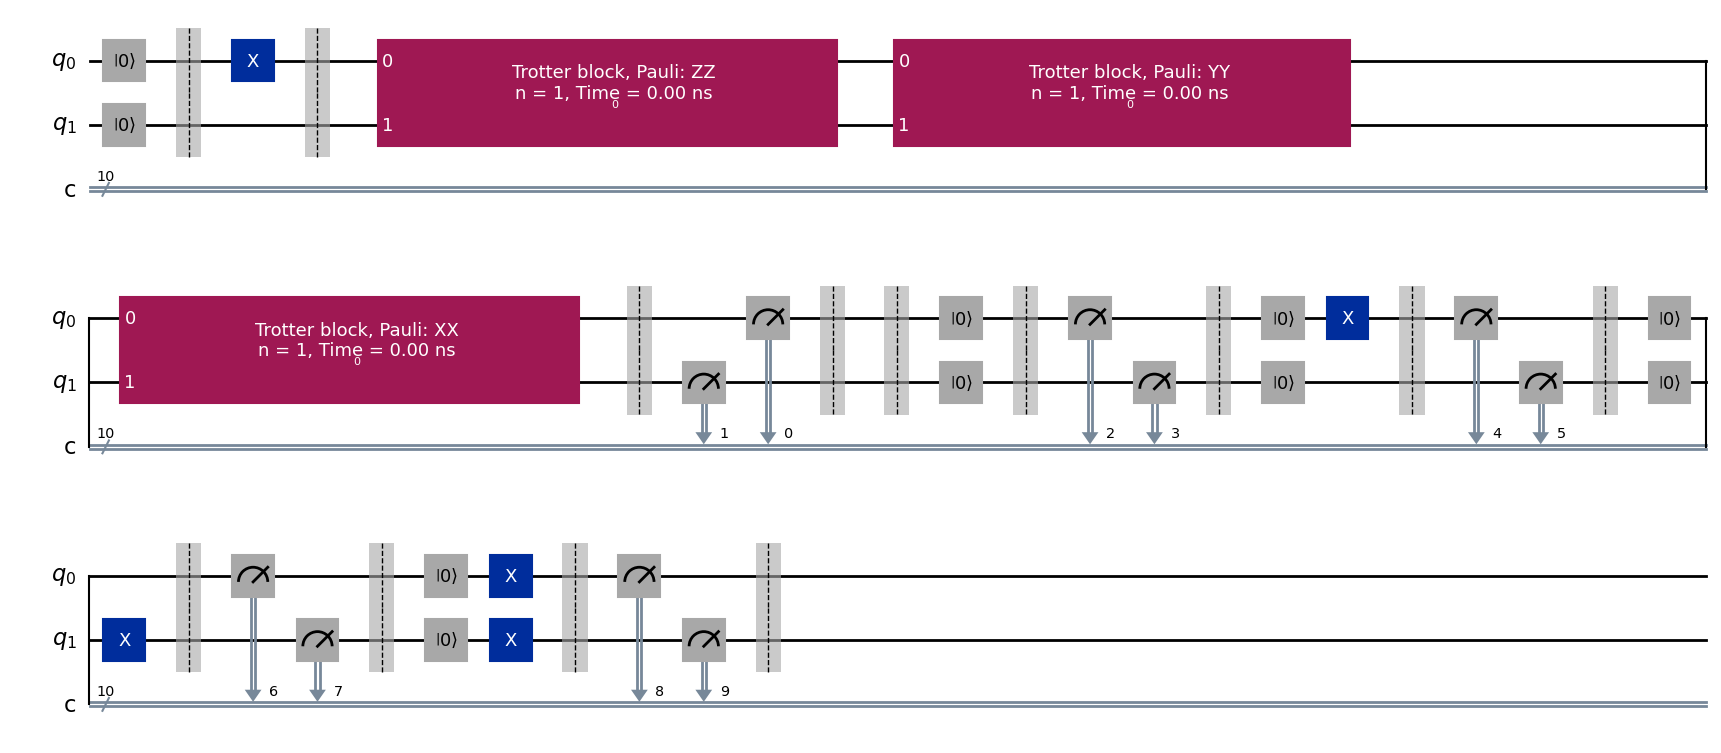

In [11]:
qc_list[0].draw('mpl')

## 5.2. Transpiling all circuits

In [12]:
superconducting_basis_gates = ['id', 'z', 's', 'sdg', 't', 'tdg', 'x', 'rx', 'y', 'ry', 'cz', 'delay', 'reset']
qubit_list = [0, 2]

transpiled_qc_list = []
for qc_idx in range(len(qc_list)):
    qc_transpiled = transpile(qc_list[qc_idx],
                              backend,
                              initial_layout=qubit_list,
                              basis_gates=superconducting_basis_gates)
    
    transpiled_qc_list.append(qc_transpiled)

/opt/miniconda3/envs/quantuminspire/lib/python3.12/site-packages/qiskit/compiler/transpiler.py:269: UserWarning: Providing `coupling_map` and/or `basis_gates` along with `backend` is not recommended, as this will invalidate the backend's gate durations and error rates.
  pm = generate_preset_pass_manager(


## 5.3. Submitting the job and collecting the results

In [13]:
nr_shots = 2**12 # NOTE: adjust accordingly in case the memory limitation of the
                 # readout instruments is exceeded
job = backend.run(transpiled_qc_list, shots=nr_shots, memory=True)
result = job.result(timeout = 600)
StoreProjectRecord(job)

Successfully stored project record in the following directory:
/Users/mariossamiotis/Documents/QuantumInspireProjects/20260119/162606_Trotterization_ZZ_Timestep_0



## 5.4. Results gathering and post-processing

### 5.4.1. Collecting the raw data shots and extracting the readout assignment matrix

In [14]:
raw_data_shots_per_circuit = []

raw_data_shots_0, ro_mitigation_shots = split_raw_shots(result, qubit_list, circuit_nr=0)
raw_data_shots_per_circuit.append(raw_data_shots_0)
ro_assignment_matrix = extract_ro_assignment_matrix(ro_mitigation_shots, qubit_list)

for circuit_idx in range(1, len(qc_list)):
    raw_data_shots = get_raw_data(qc_list[1], result, circuit_idx)
    raw_data_shots_per_circuit.append(raw_data_shots)

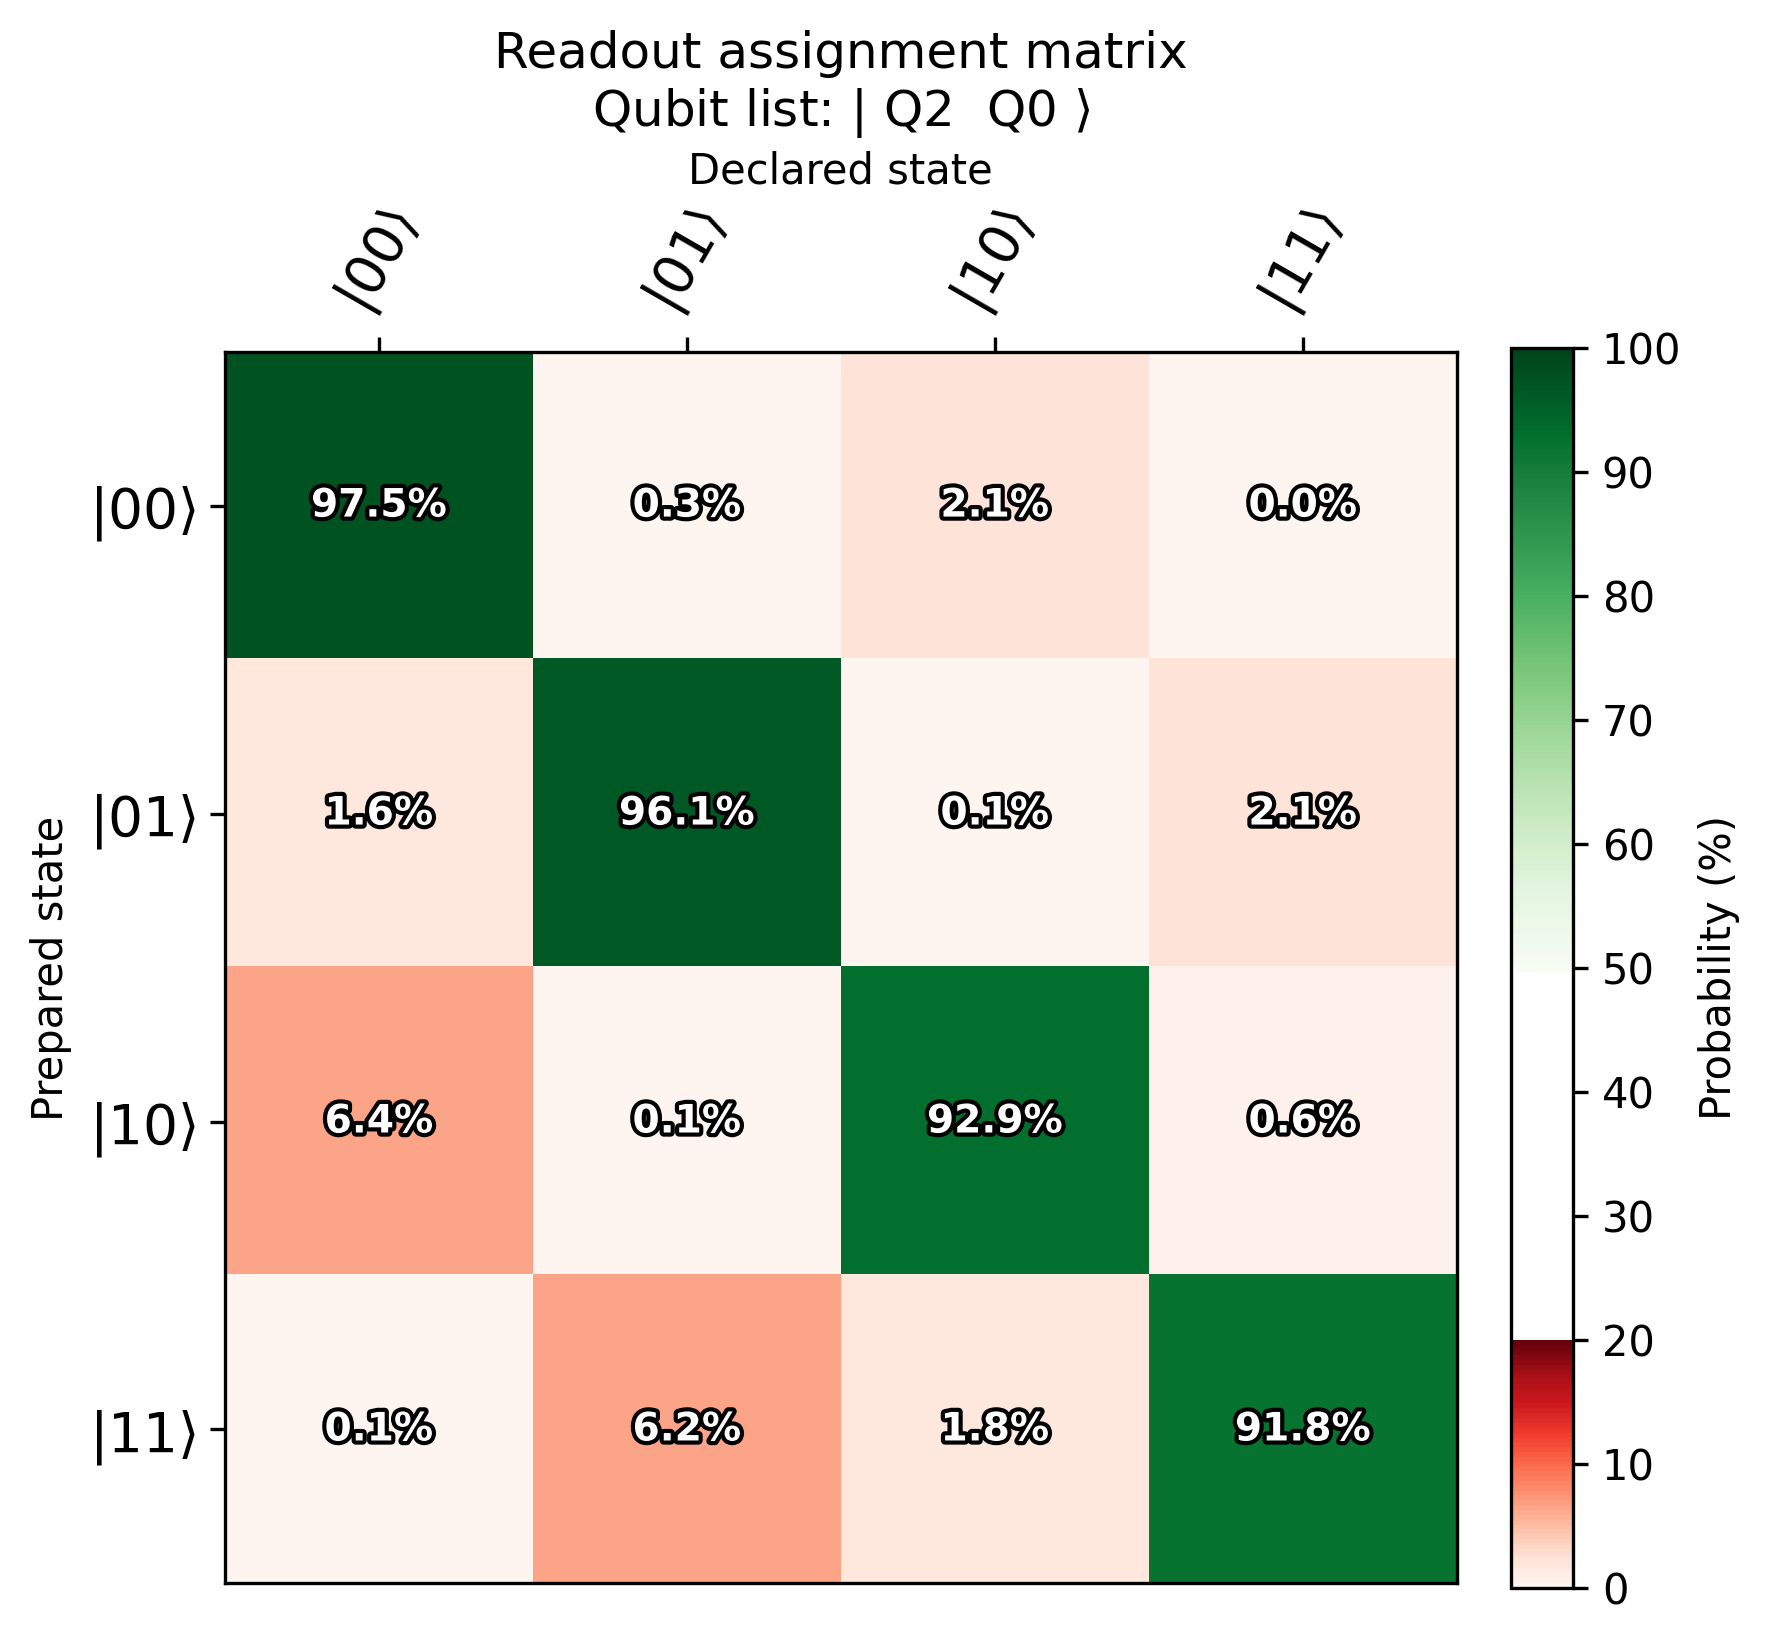

In [15]:
plot_ro_assignment_matrix(ro_assignment_matrix, qubit_list)

### 5.4.2. Gathering result probabilities and applying readout error mitigation

In [16]:
raw_data_probs_per_circuit = []
ro_corrected_probs_per_circuit = []

for circuit_idx in range(len(qc_list)):
    raw_data_counts = get_multi_counts(raw_data_shots_per_circuit[circuit_idx], len(qubit_list))

    raw_data_probs = get_multi_probs(raw_data_counts)
    raw_data_probs_per_circuit.append(raw_data_probs[0])

    ro_corrected_probs = get_ro_corrected_multi_probs(raw_data_probs, ro_assignment_matrix, qubit_list)
    ro_corrected_probs_per_circuit.append(ro_corrected_probs[0])

In [17]:
IZ_values = observable_expectation_values_Z_basis(raw_data_probs_per_circuit, 'IZ')
ZI_values = observable_expectation_values_Z_basis(raw_data_probs_per_circuit, 'ZI')

IZ_values_ro_corrected = observable_expectation_values_Z_basis(ro_corrected_probs_per_circuit, 'IZ')
ZI_values_ro_corrected = observable_expectation_values_Z_basis(ro_corrected_probs_per_circuit, 'ZI')

### 5.4.3. Plotting the final results

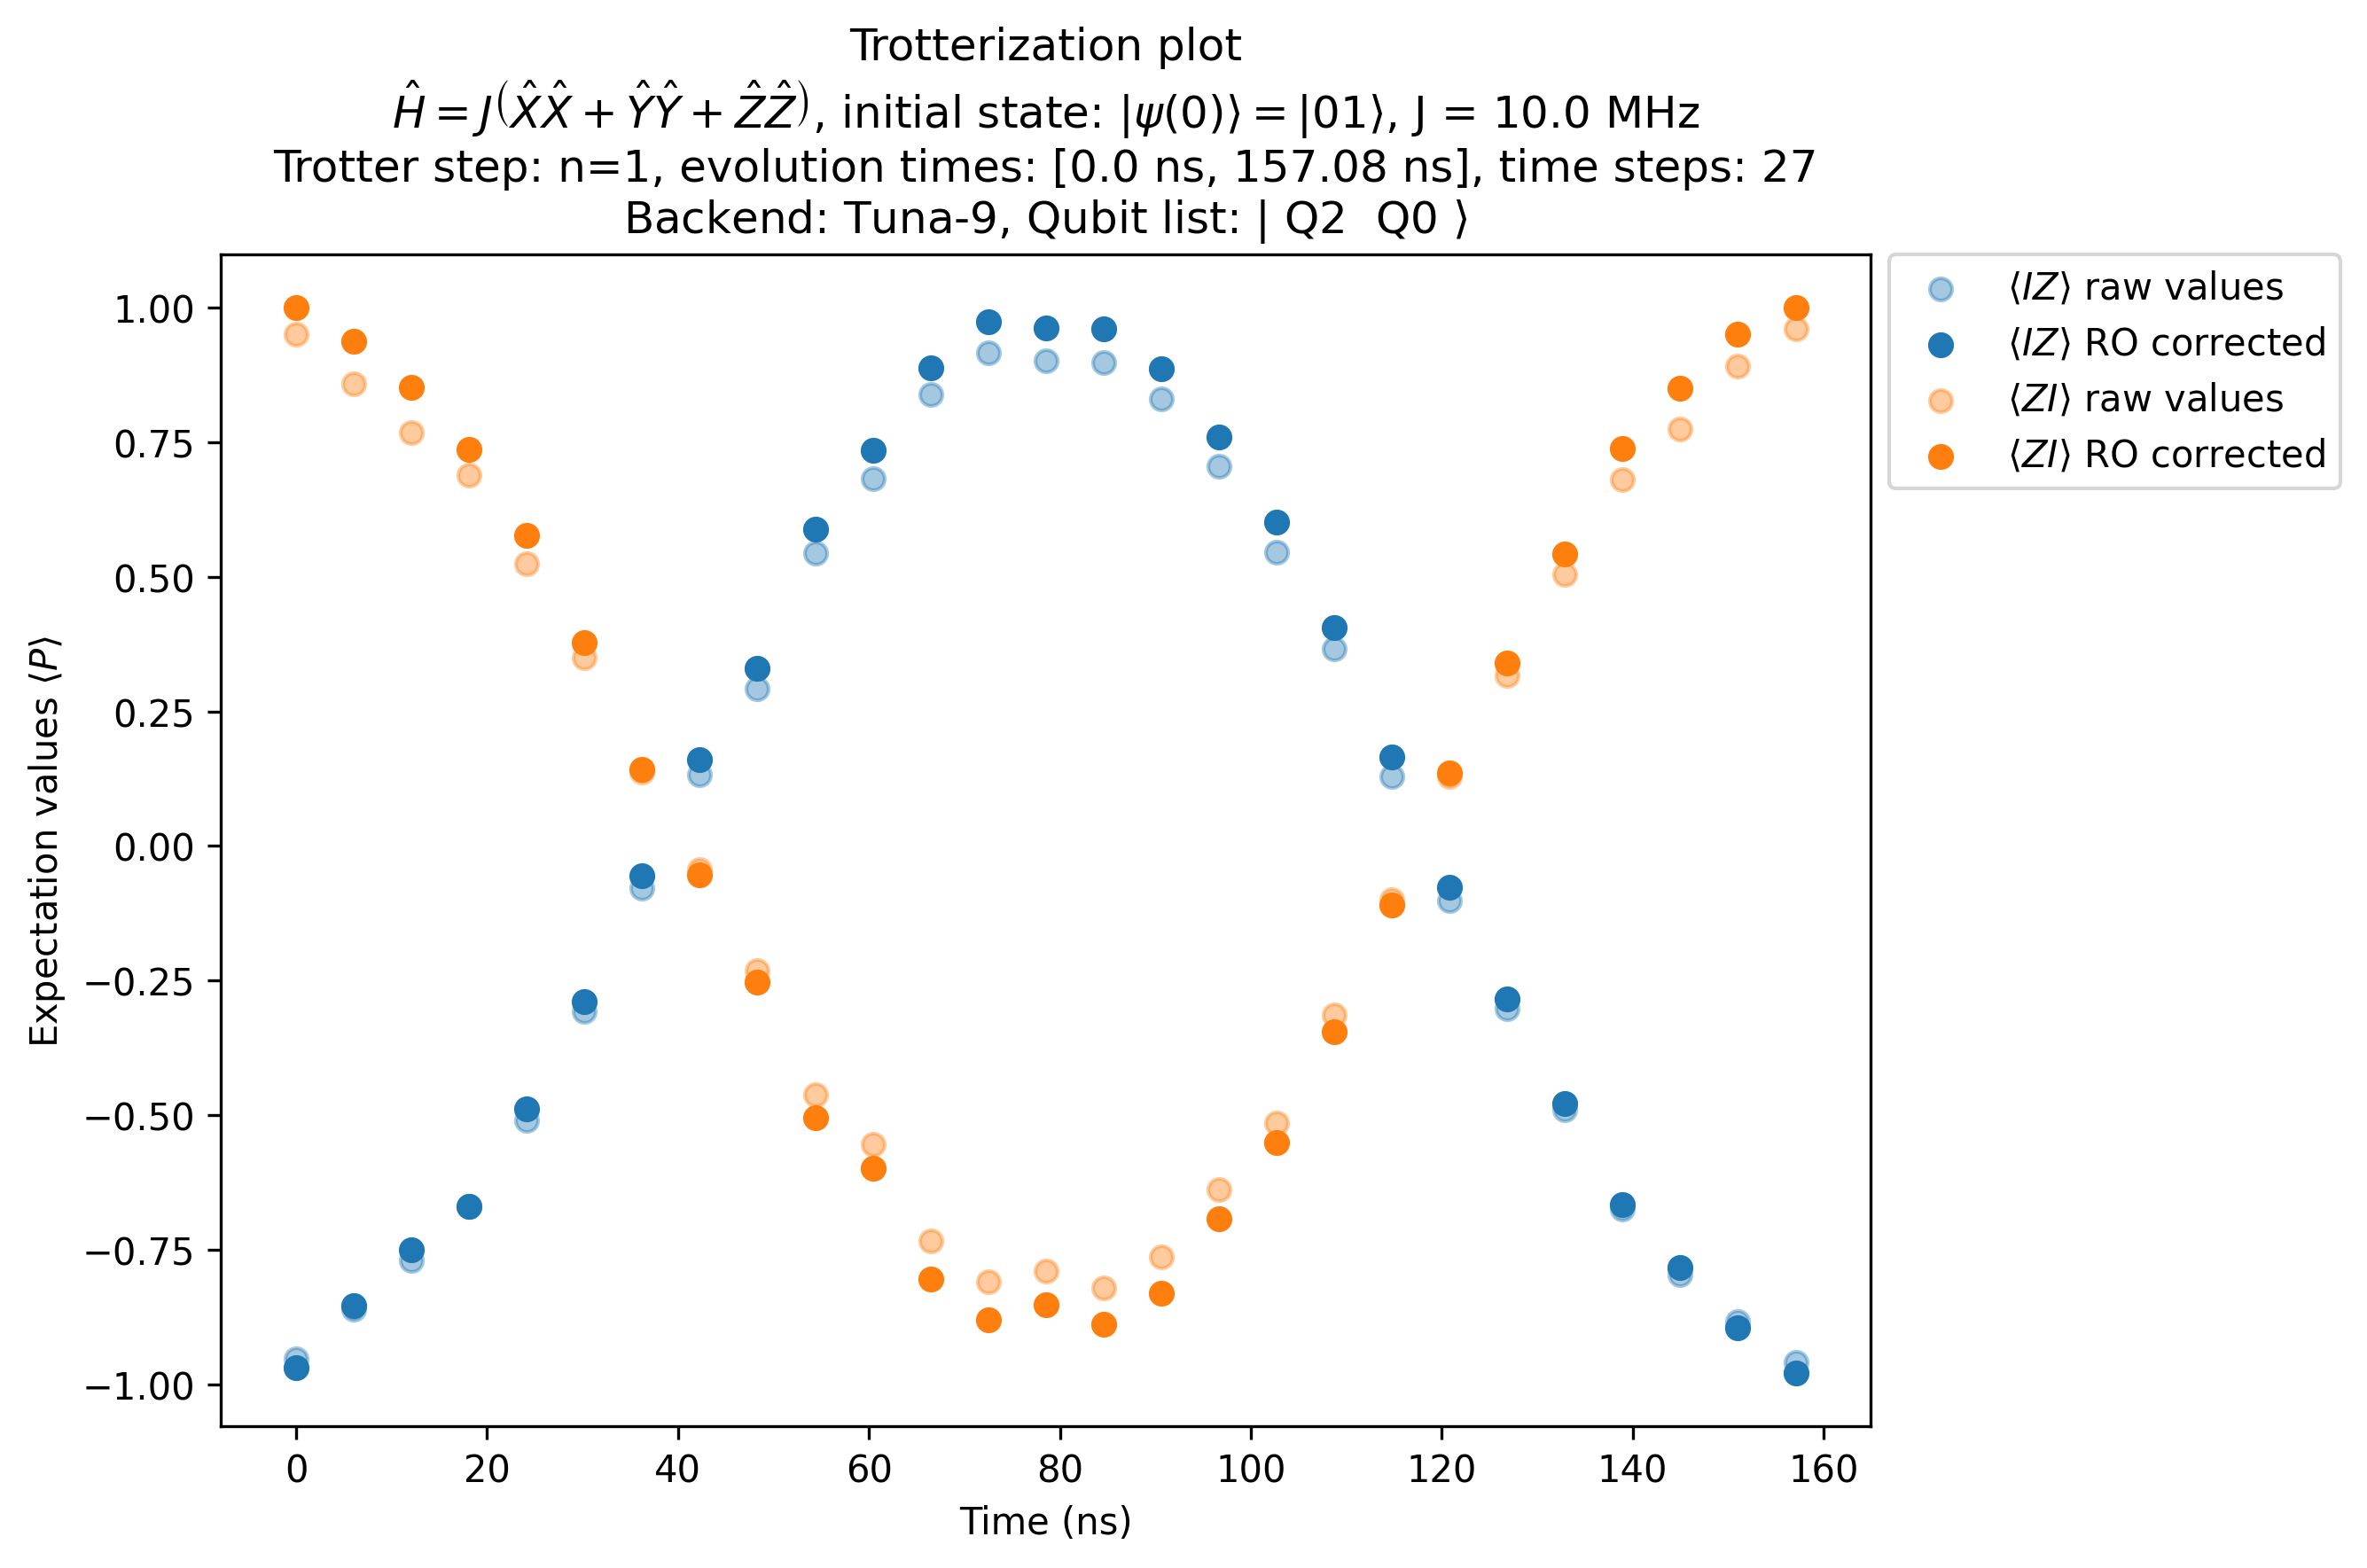

In [18]:
fig, ax = plt.subplots(figsize=(9, 6), dpi=300)

ax.scatter(evolution_times*1e9, IZ_values, label=r'$\langle IZ \rangle$ raw values', color='C0', alpha=0.4)
ax.scatter(evolution_times*1e9, IZ_values_ro_corrected, label=r'$\langle IZ \rangle$ RO corrected', color='C0')

ax.scatter(evolution_times*1e9, ZI_values, label=r'$\langle ZI \rangle$ raw values', color='C1', alpha=0.4)
ax.scatter(evolution_times*1e9, ZI_values_ro_corrected, label=r'$\langle ZI \rangle$ RO corrected', color='C1')

qubit_list_label = r"$|$"
for qubit_idx in qubit_list[::-1]:
   qubit_list_label += f" Q{qubit_idx} "
qubit_list_label += r"$\rangle$"
ax.set_xlabel('Time (ns)')
ax.set_ylabel(r'Expectation values $\langle P \rangle $')
ax.set_title('Trotterization plot\n' \
             r'$\hat{H} = J \left( \hat{X}\hat{X} + \hat{Y}\hat{Y} + \hat{Z}\hat{Z} \right)$, ' \
             r'initial state: $|\psi(0) \rangle = |$' f'{initial_state}' r'$\rangle$, ' r'J = ' f'{J/1e6} MHz' \
             f'\nTrotter step: n={trotter_order}, evolution times: [{np.round(evolution_times[0]*1e9, 2)} ns, ' \
                f'{np.round(evolution_times[-1]*1e9, 2)} ns], time steps: {len(evolution_times)}\n' \
             f'Backend: {result.backend_name}, Qubit list: {qubit_list_label}')

ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.9))

plt.tight_layout()
plt.show()

## 5.5. Comparing experimental results with the exact solution

In [19]:
initial_state_qc = QuantumCircuit(2)
# Initialization to the |01> state
if len(initial_state) != nr_qubits:
    raise ValueError('Initial state must have same number of qubits defined.')
for idx in range(len(initial_state)):
    if initial_state[idx] == '1':
        initial_state_qc.x((nr_qubits-1) - idx)

observables = simulate_time_evolution(initial_state_qc,
                                      hamiltonian_operator,
                                      evolution_times,
                                      ['IZ', 'ZI'])

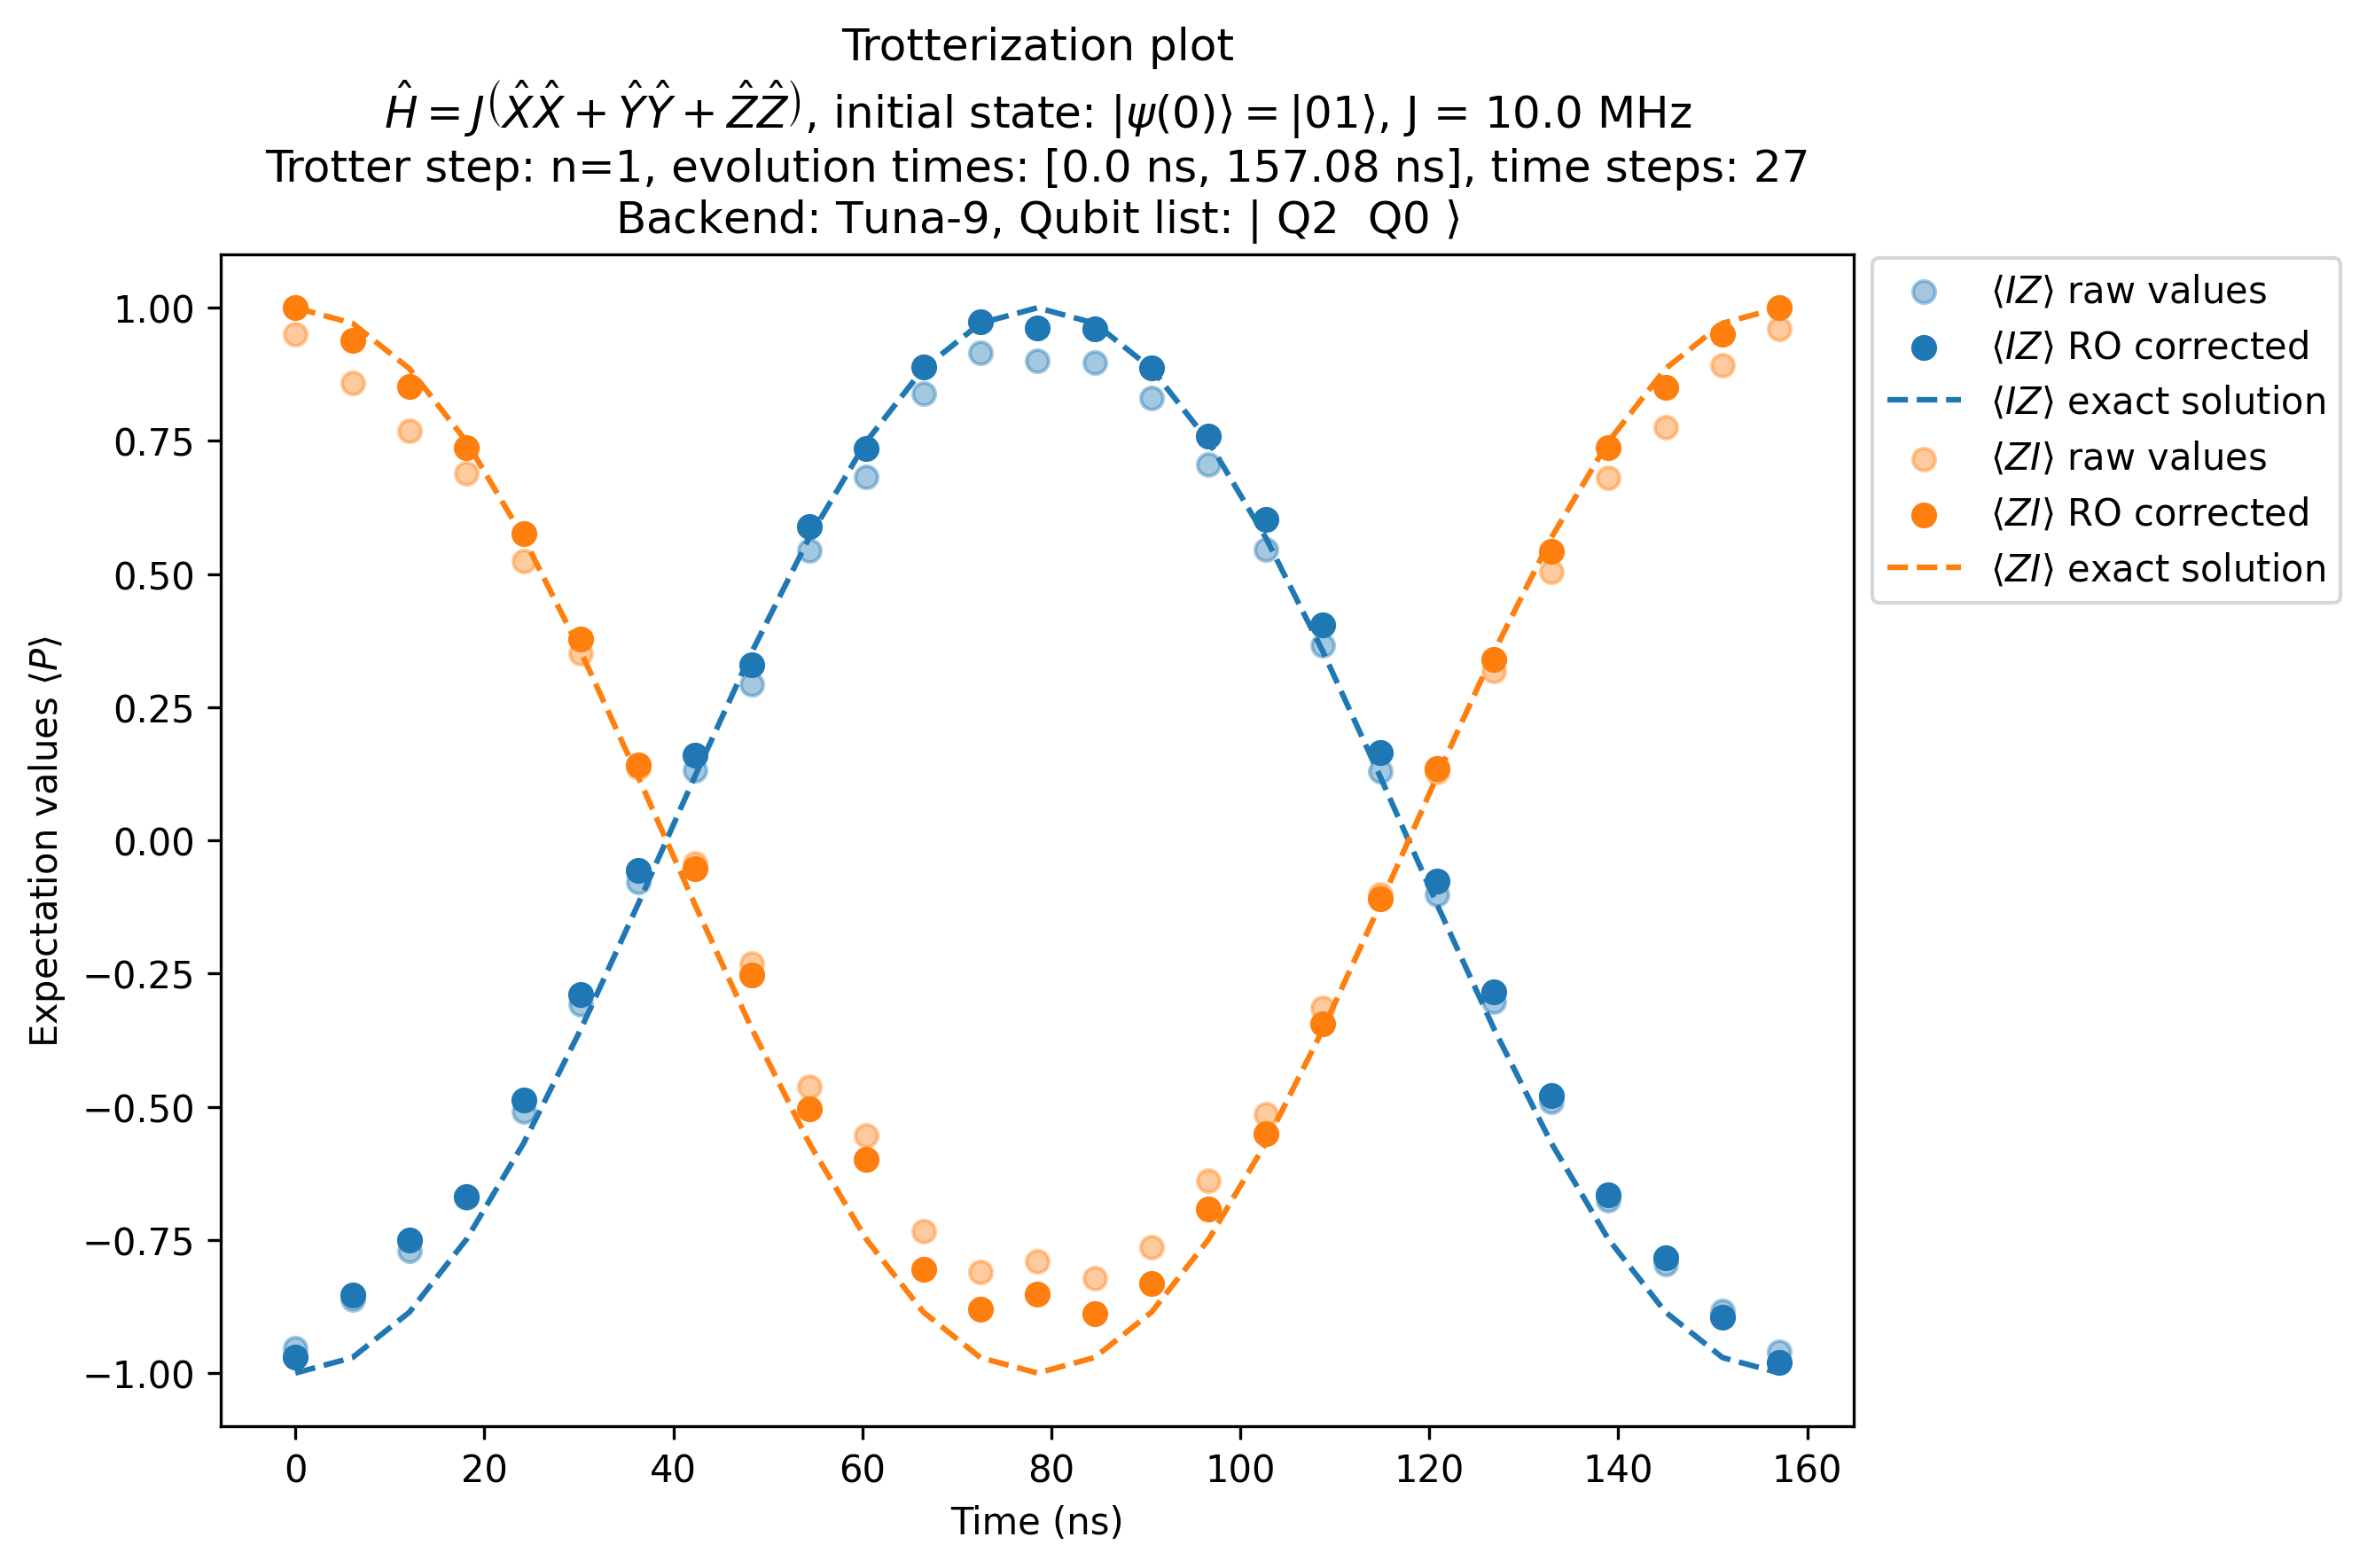

In [20]:
fig, ax = plt.subplots(figsize=(9, 6), dpi=300)

ax.scatter(evolution_times*1e9, IZ_values, label=r'$\langle IZ \rangle$ raw values', color='C0', alpha=0.4)
ax.scatter(evolution_times*1e9, IZ_values_ro_corrected, label=r'$\langle IZ \rangle$ RO corrected', color='C0')
ax.plot(evolution_times*1e9, observables['IZ']['values'], label=r'$\langle IZ \rangle$ exact solution', color='C0', linestyle='--')

ax.scatter(evolution_times*1e9, ZI_values, label=r'$\langle ZI \rangle$ raw values', color='C1', alpha=0.4)
ax.scatter(evolution_times*1e9, ZI_values_ro_corrected, label=r'$\langle ZI \rangle$ RO corrected', color='C1')
ax.plot(evolution_times*1e9, observables['ZI']['values'], label=r'$\langle ZI \rangle$ exact solution', color='C1', linestyle='--')

qubit_list_label = r"$|$"
for qubit_idx in qubit_list[::-1]:
   qubit_list_label += f" Q{qubit_idx} "
qubit_list_label += r"$\rangle$"
ax.set_xlabel('Time (ns)')
ax.set_ylabel(r'Expectation values $\langle P \rangle $')
ax.set_title('Trotterization plot\n' \
             r'$\hat{H} = J \left( \hat{X}\hat{X} + \hat{Y}\hat{Y} + \hat{Z}\hat{Z} \right)$, ' \
             r'initial state: $|\psi(0) \rangle = |$' f'{initial_state}' r'$\rangle$, ' r'J = ' f'{J/1e6} MHz' \
             f'\nTrotter step: n={trotter_order}, evolution times: [{np.round(evolution_times[0]*1e9, 2)} ns, ' \
                f'{np.round(evolution_times[-1]*1e9, 2)} ns], time steps: {len(evolution_times)}\n' \
             f'Backend: {result.backend_name}, Qubit list: {qubit_list_label}')

ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.85))

plt.tight_layout()
plt.show()

# 6. [SOLUTION METHOD 2] 'Stitch' all circuits into one using mid-circuit measurements

## 6.1. Creating a single circuit containing all time evolution steps

In [21]:
qc = QuantumCircuit(nr_qubits, nr_qubits*len(evolution_times), name=f"trotterization_heisenberg_{measured_observable}")

for time_step in range(len(evolution_times)):
    qc_step = construct_trotterization_circuit(initial_state,
                                               measured_observable,
                                               hamiltonian_operator,
                                               trotter_order,
                                               evolution_times,
                                               time_step=time_step,
                                               midcircuit_measurement = True)
    qc = qc.compose(qc_step)

qc = apply_readout_circuit(qc, list(range(nr_qubits)))

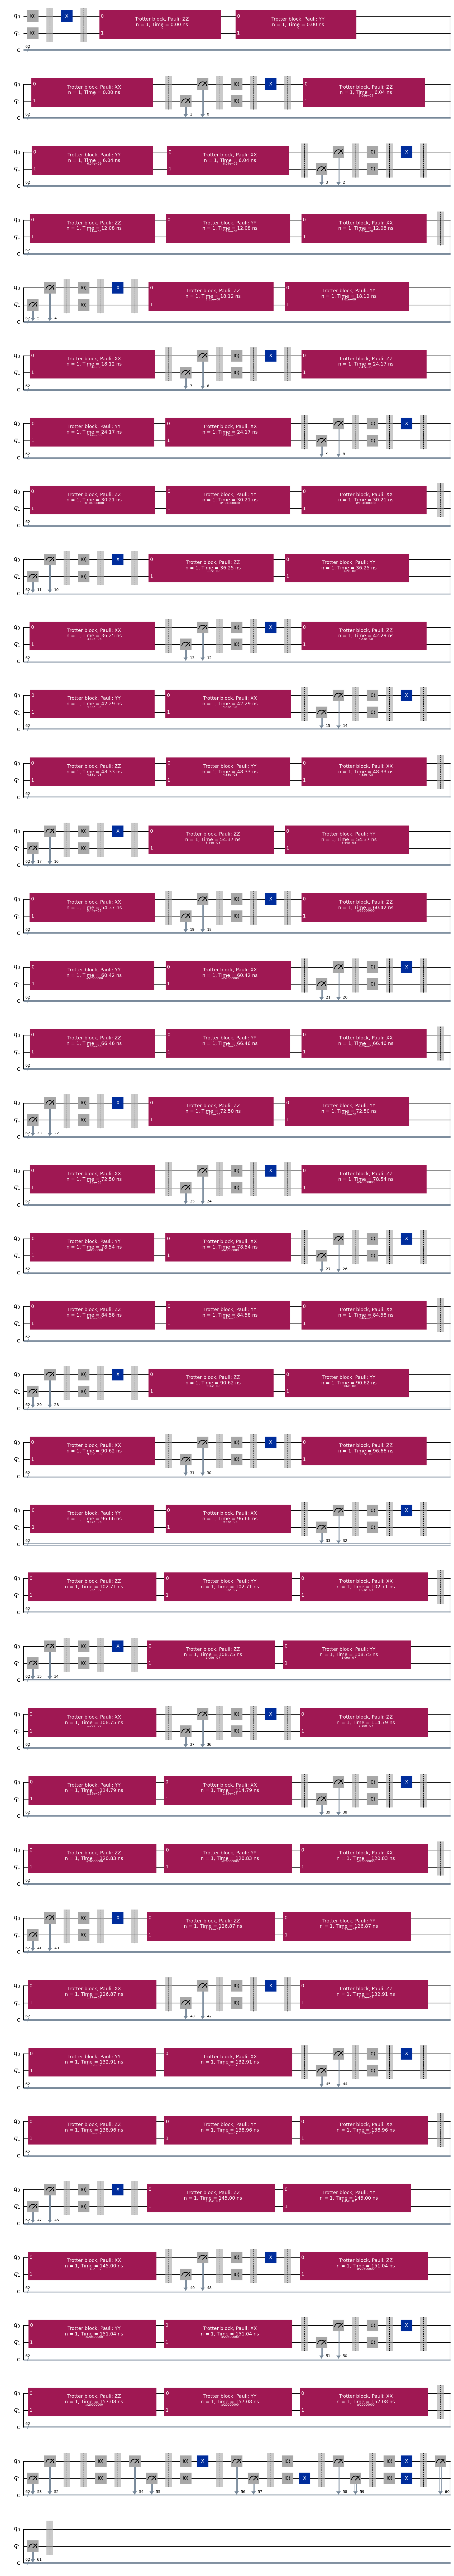

In [22]:
qc.draw('mpl')

## 6.2 Transpiling all circuits

In [23]:
superconducting_basis_gates = ['id', 'z', 's', 'sdg', 't', 'tdg', 'x', 'rx', 'y', 'ry', 'cz', 'delay', 'reset']
qubit_list = [0, 2]

qc_transpiled = transpile(qc,
                          backend,
                          initial_layout=qubit_list,
                          basis_gates=superconducting_basis_gates)

/opt/miniconda3/envs/quantuminspire/lib/python3.12/site-packages/qiskit/compiler/transpiler.py:269: UserWarning: Providing `coupling_map` and/or `basis_gates` along with `backend` is not recommended, as this will invalidate the backend's gate durations and error rates.
  pm = generate_preset_pass_manager(


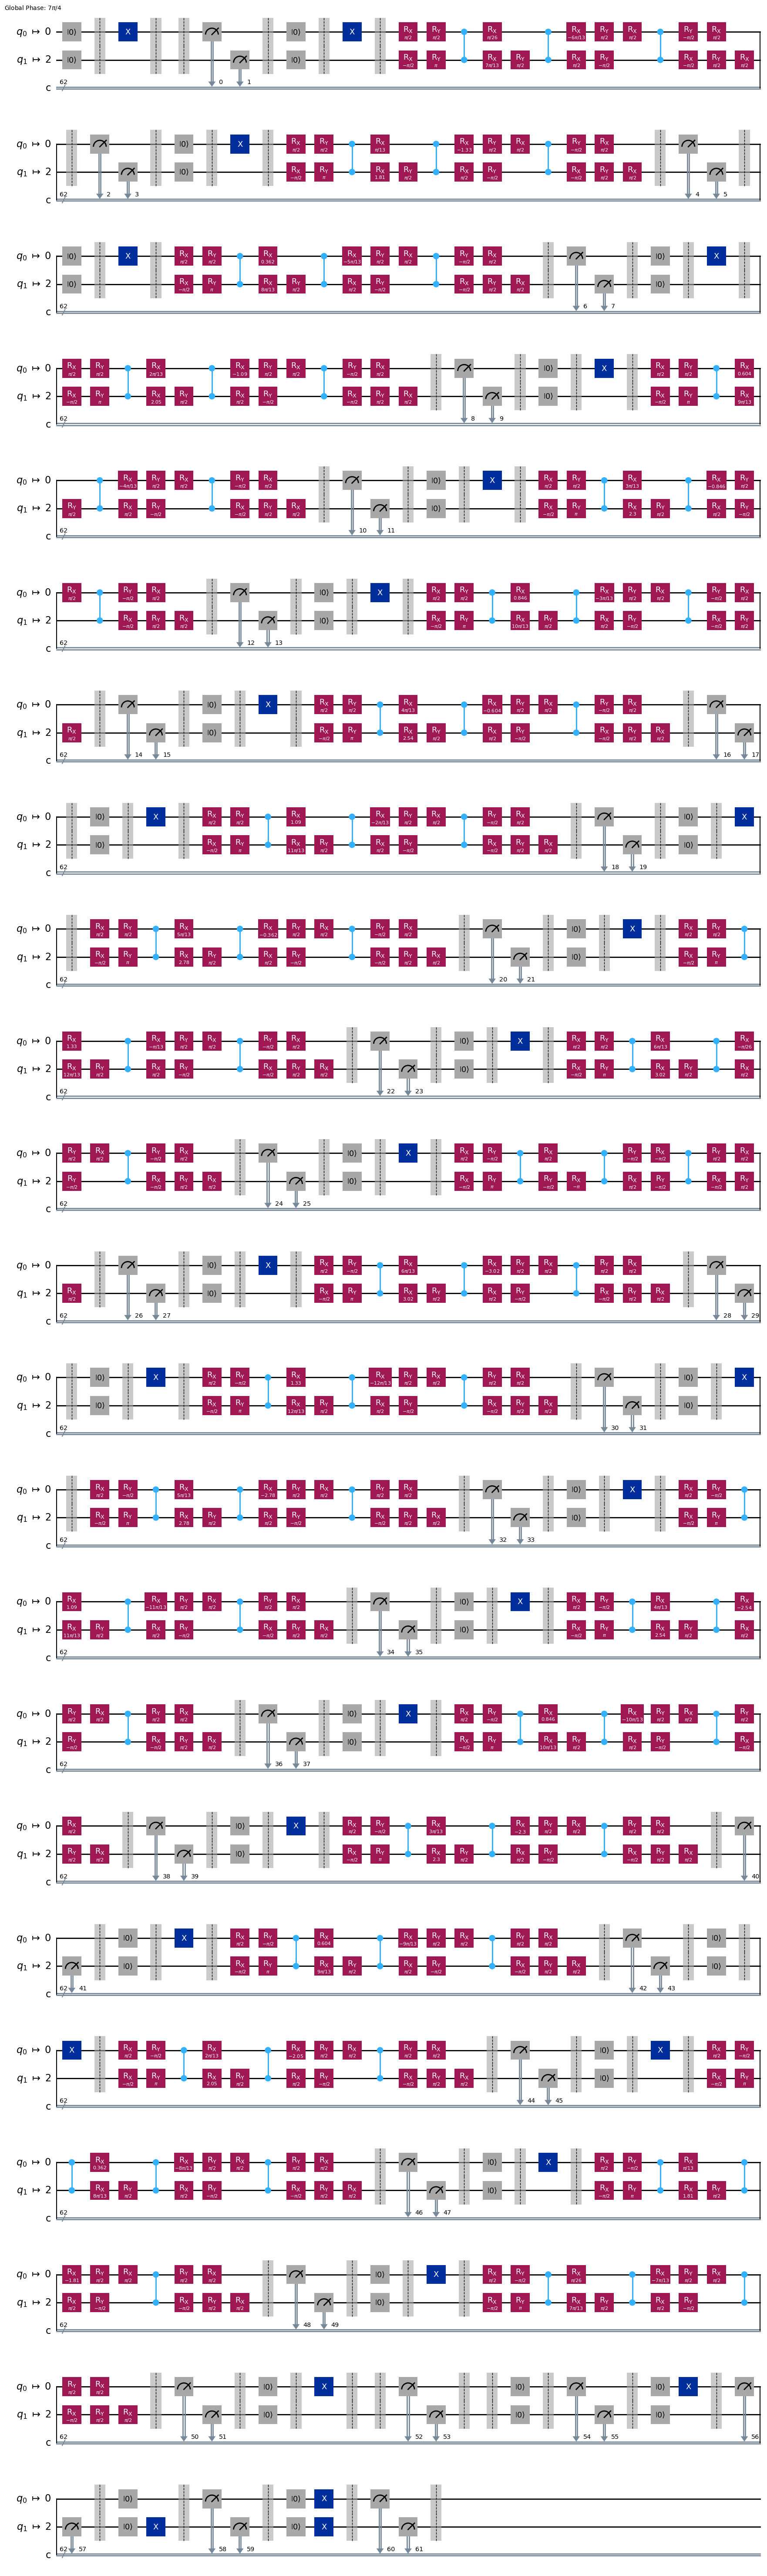

In [24]:
qc_transpiled.draw('mpl')

## 6.3. Submitting the job and collecting the results

In [25]:
nr_shots = 2**11 # NOTE: adjust accordingly in case the memory limitation of the
                 # readout instruments is exceeded
job = backend.run(qc_transpiled, shots=nr_shots, memory=True)
result = job.result(timeout = 600)
StoreProjectRecord(job)

Successfully stored project record in the following directory:
/Users/mariossamiotis/Documents/QuantumInspireProjects/20260119/162917_trotterization_heisenberg_ZZ



## 6.4 Results gathering and post-processing

### 6.4.1. Collecting the raw data shots and extracting the readout assignment matrix

In [26]:
raw_data_shots, ro_mitigation_shots = split_raw_shots(result, qubit_list)
ro_assignment_matrix = extract_ro_assignment_matrix(ro_mitigation_shots, qubit_list)

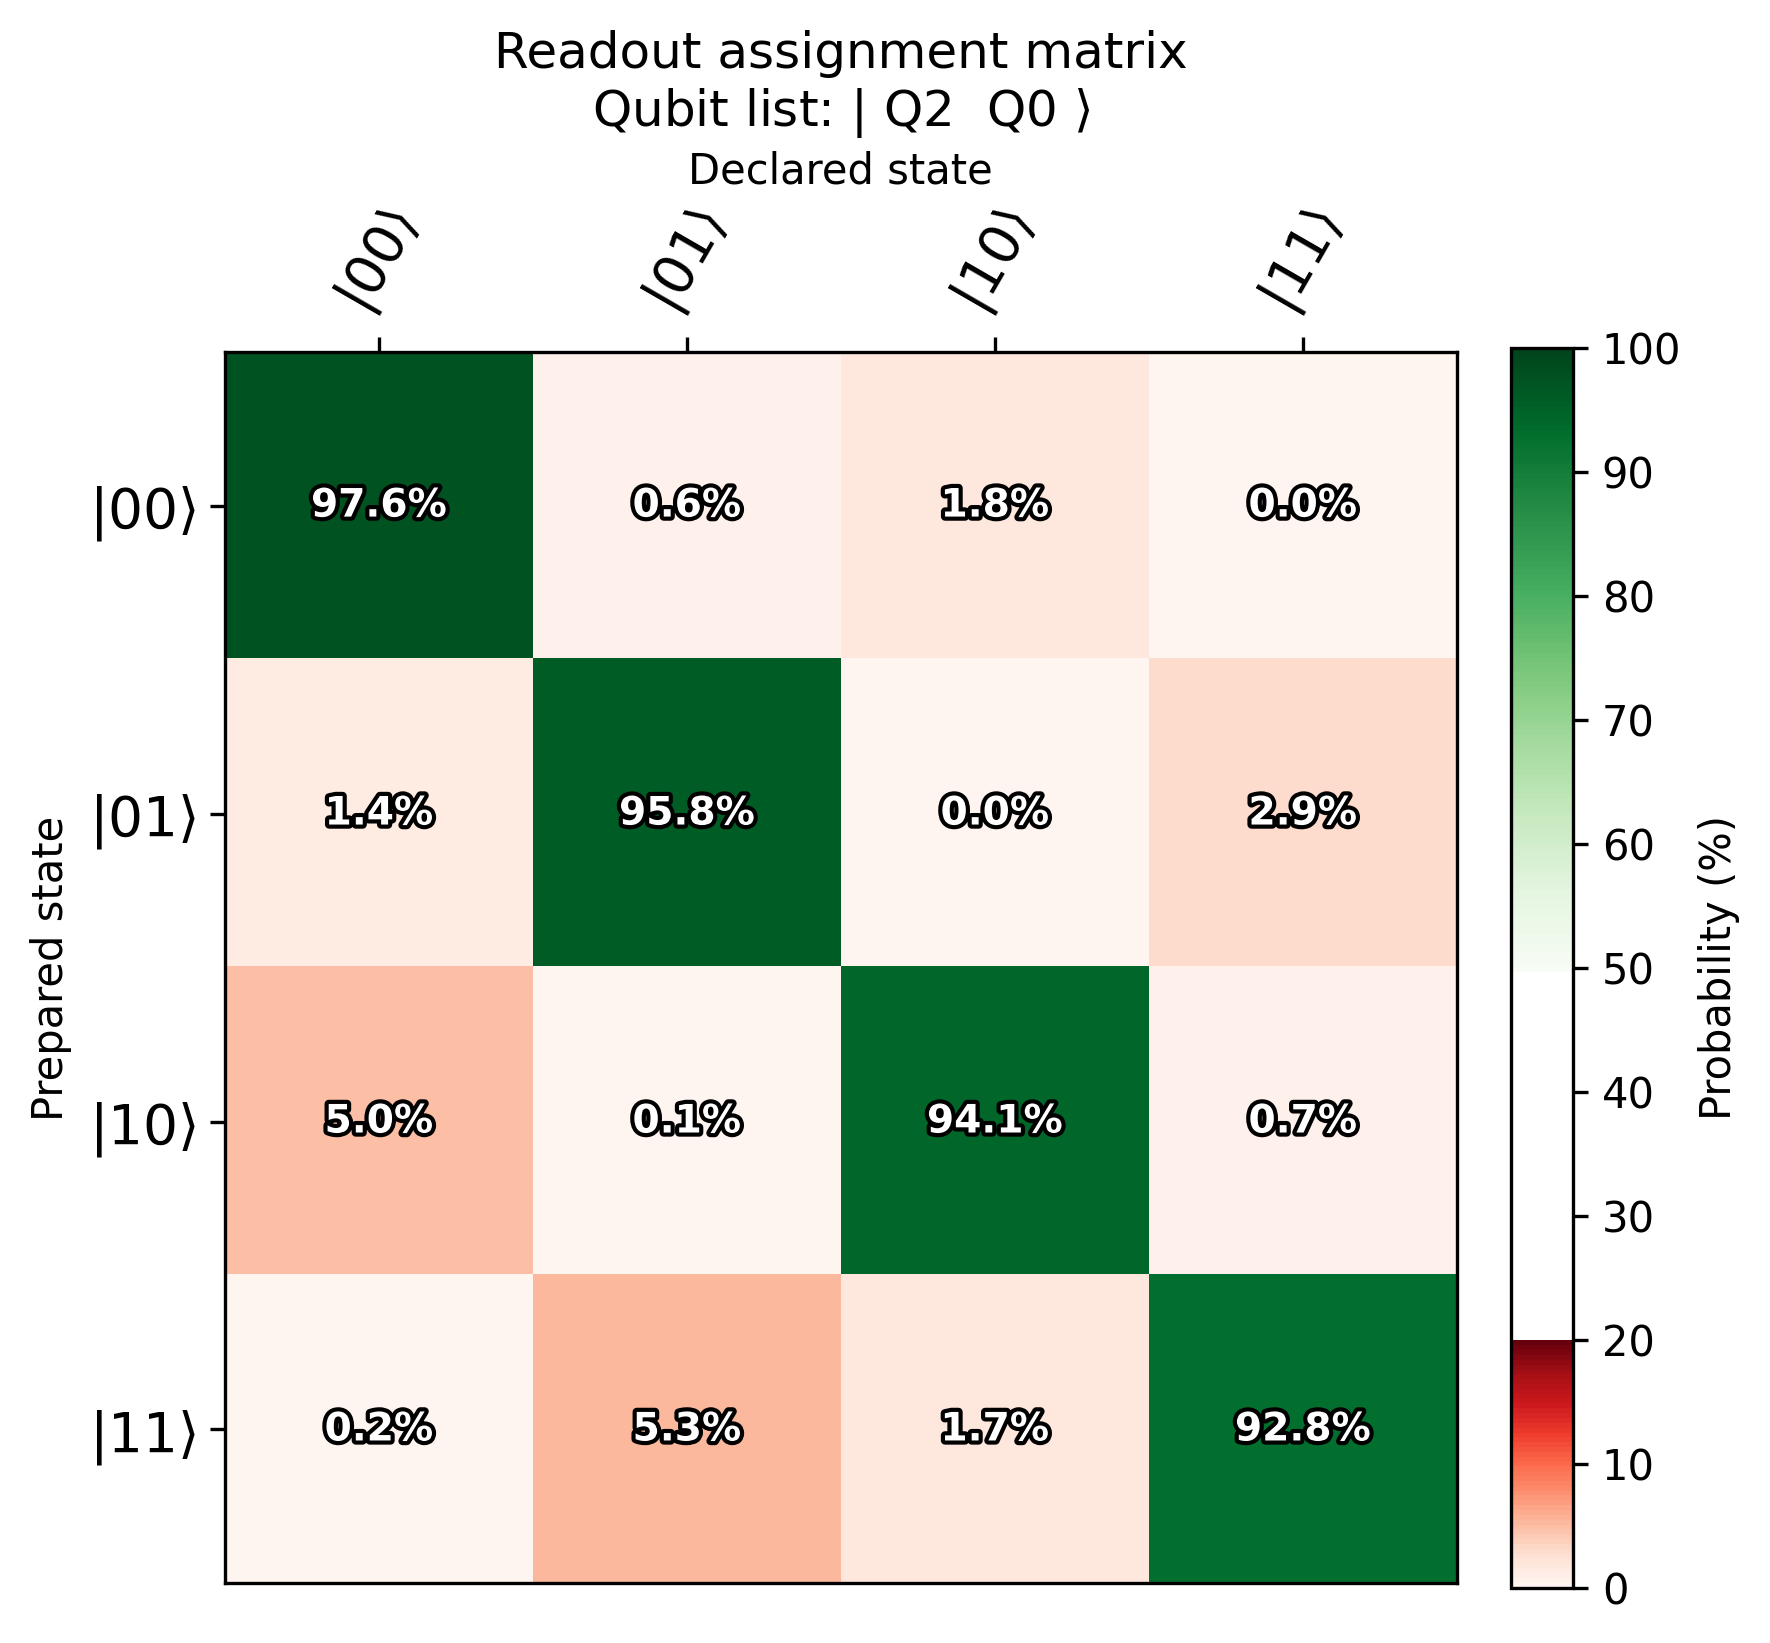

In [27]:
plot_ro_assignment_matrix(ro_assignment_matrix, qubit_list)

### 6.4.2. Gathering result probabilities and applying readout error mitigation

In [28]:
raw_data_counts = get_multi_counts(raw_data_shots, len(qubit_list))
raw_data_probs = get_multi_probs(raw_data_counts)
ro_corrected_probs = get_ro_corrected_multi_probs(raw_data_probs, ro_assignment_matrix, qubit_list)

In [29]:
IZ_values = observable_expectation_values_Z_basis(raw_data_probs, 'IZ')
ZI_values = observable_expectation_values_Z_basis(raw_data_probs, 'ZI')

IZ_values_ro_corrected = observable_expectation_values_Z_basis(ro_corrected_probs, 'IZ')
ZI_values_ro_corrected = observable_expectation_values_Z_basis(ro_corrected_probs, 'ZI')

### 6.4.3. Plotting the final results

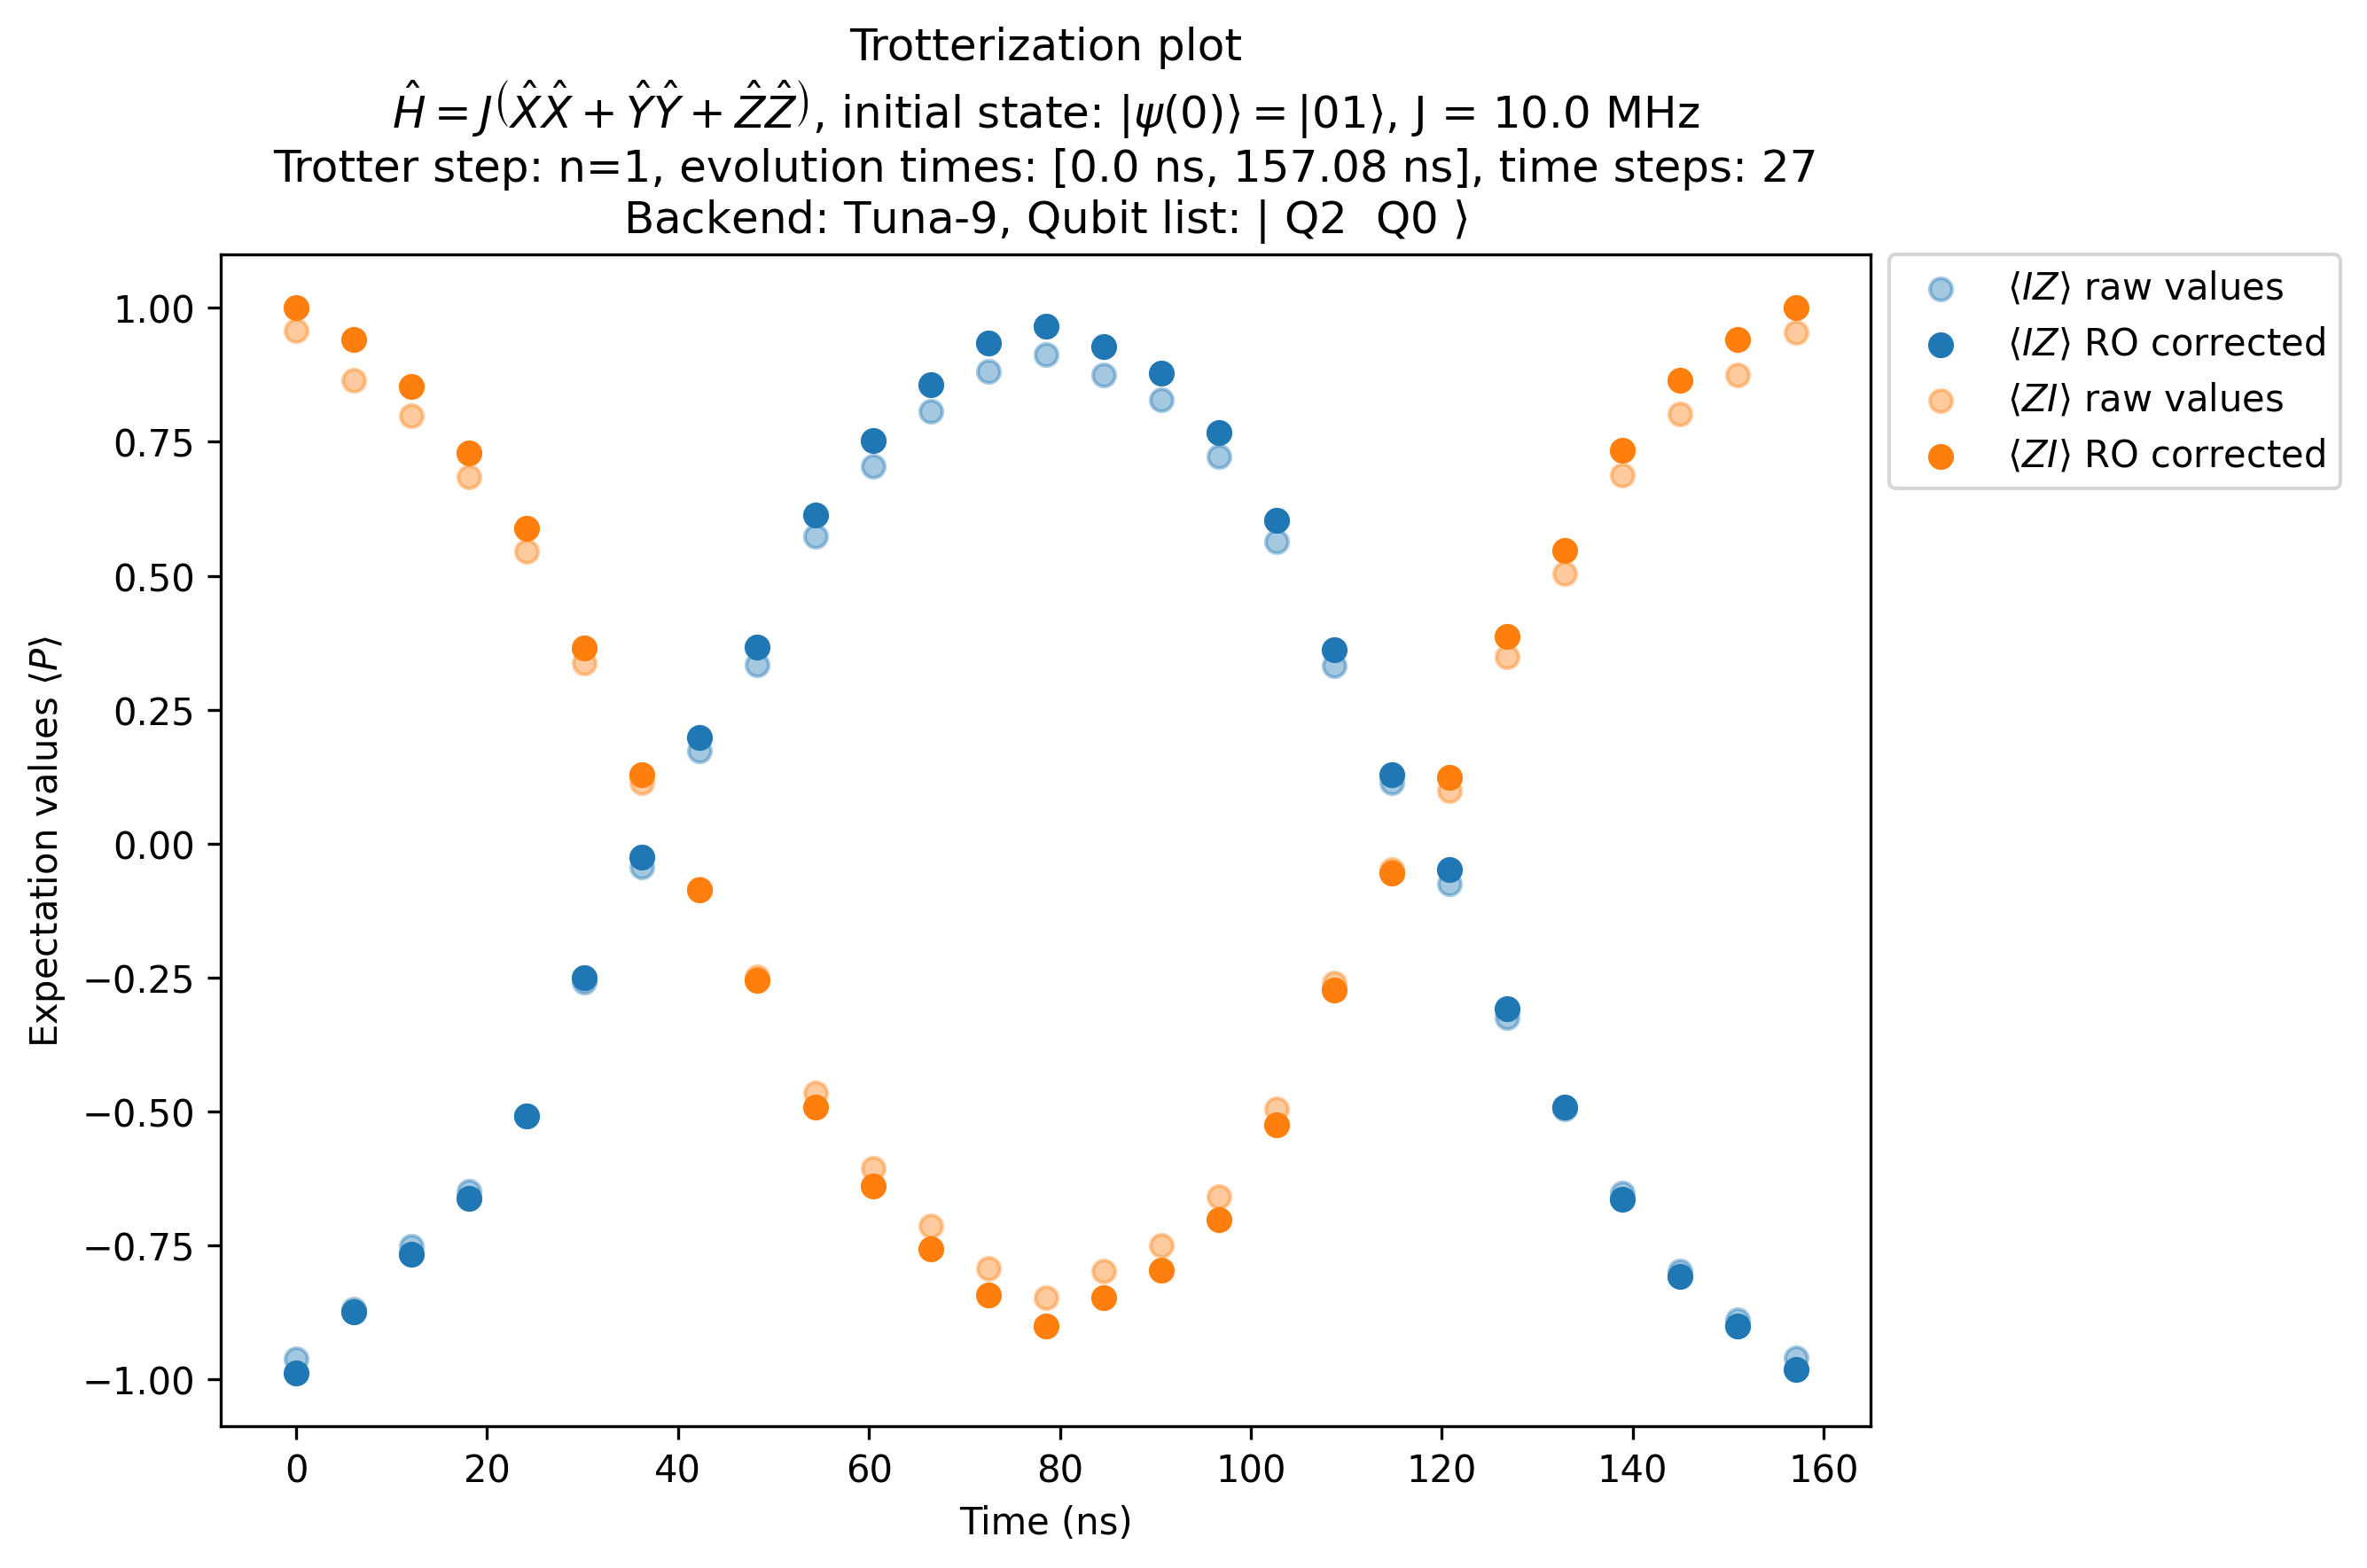

In [30]:
fig, ax = plt.subplots(figsize=(9, 6), dpi=300)

ax.scatter(evolution_times*1e9, IZ_values, label=r'$\langle IZ \rangle$ raw values', color='C0', alpha=0.4)
ax.scatter(evolution_times*1e9, IZ_values_ro_corrected, label=r'$\langle IZ \rangle$ RO corrected', color='C0')

ax.scatter(evolution_times*1e9, ZI_values, label=r'$\langle ZI \rangle$ raw values', color='C1', alpha=0.4)
ax.scatter(evolution_times*1e9, ZI_values_ro_corrected, label=r'$\langle ZI \rangle$ RO corrected', color='C1')

qubit_list_label = r"$|$"
for qubit_idx in qubit_list[::-1]:
   qubit_list_label += f" Q{qubit_idx} "
qubit_list_label += r"$\rangle$"
ax.set_xlabel('Time (ns)')
ax.set_ylabel(r'Expectation values $\langle P \rangle $')
ax.set_title('Trotterization plot\n' \
             r'$\hat{H} = J \left( \hat{X}\hat{X} + \hat{Y}\hat{Y} + \hat{Z}\hat{Z} \right)$, ' \
             r'initial state: $|\psi(0) \rangle = |$' f'{initial_state}' r'$\rangle$, ' r'J = ' f'{J/1e6} MHz' \
             f'\nTrotter step: n={trotter_order}, evolution times: [{np.round(evolution_times[0]*1e9, 2)} ns, ' \
                f'{np.round(evolution_times[-1]*1e9, 2)} ns], time steps: {len(evolution_times)}\n' \
             f'Backend: {result.backend_name}, Qubit list: {qubit_list_label}')

ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.9))

plt.tight_layout()
plt.show()

## 6.5. Comparing experimental results with the exact solution

In [31]:
initial_state_qc = QuantumCircuit(2)
# Initialization to the |01> state
if len(initial_state) != nr_qubits:
    raise ValueError('Initial state must have same number of qubits defined.')
for idx in range(len(initial_state)):
    if initial_state[idx] == '1':
        initial_state_qc.x((nr_qubits-1) - idx)

observables = simulate_time_evolution(initial_state_qc,
                                      hamiltonian_operator,
                                      evolution_times,
                                      ['IZ', 'ZI'])

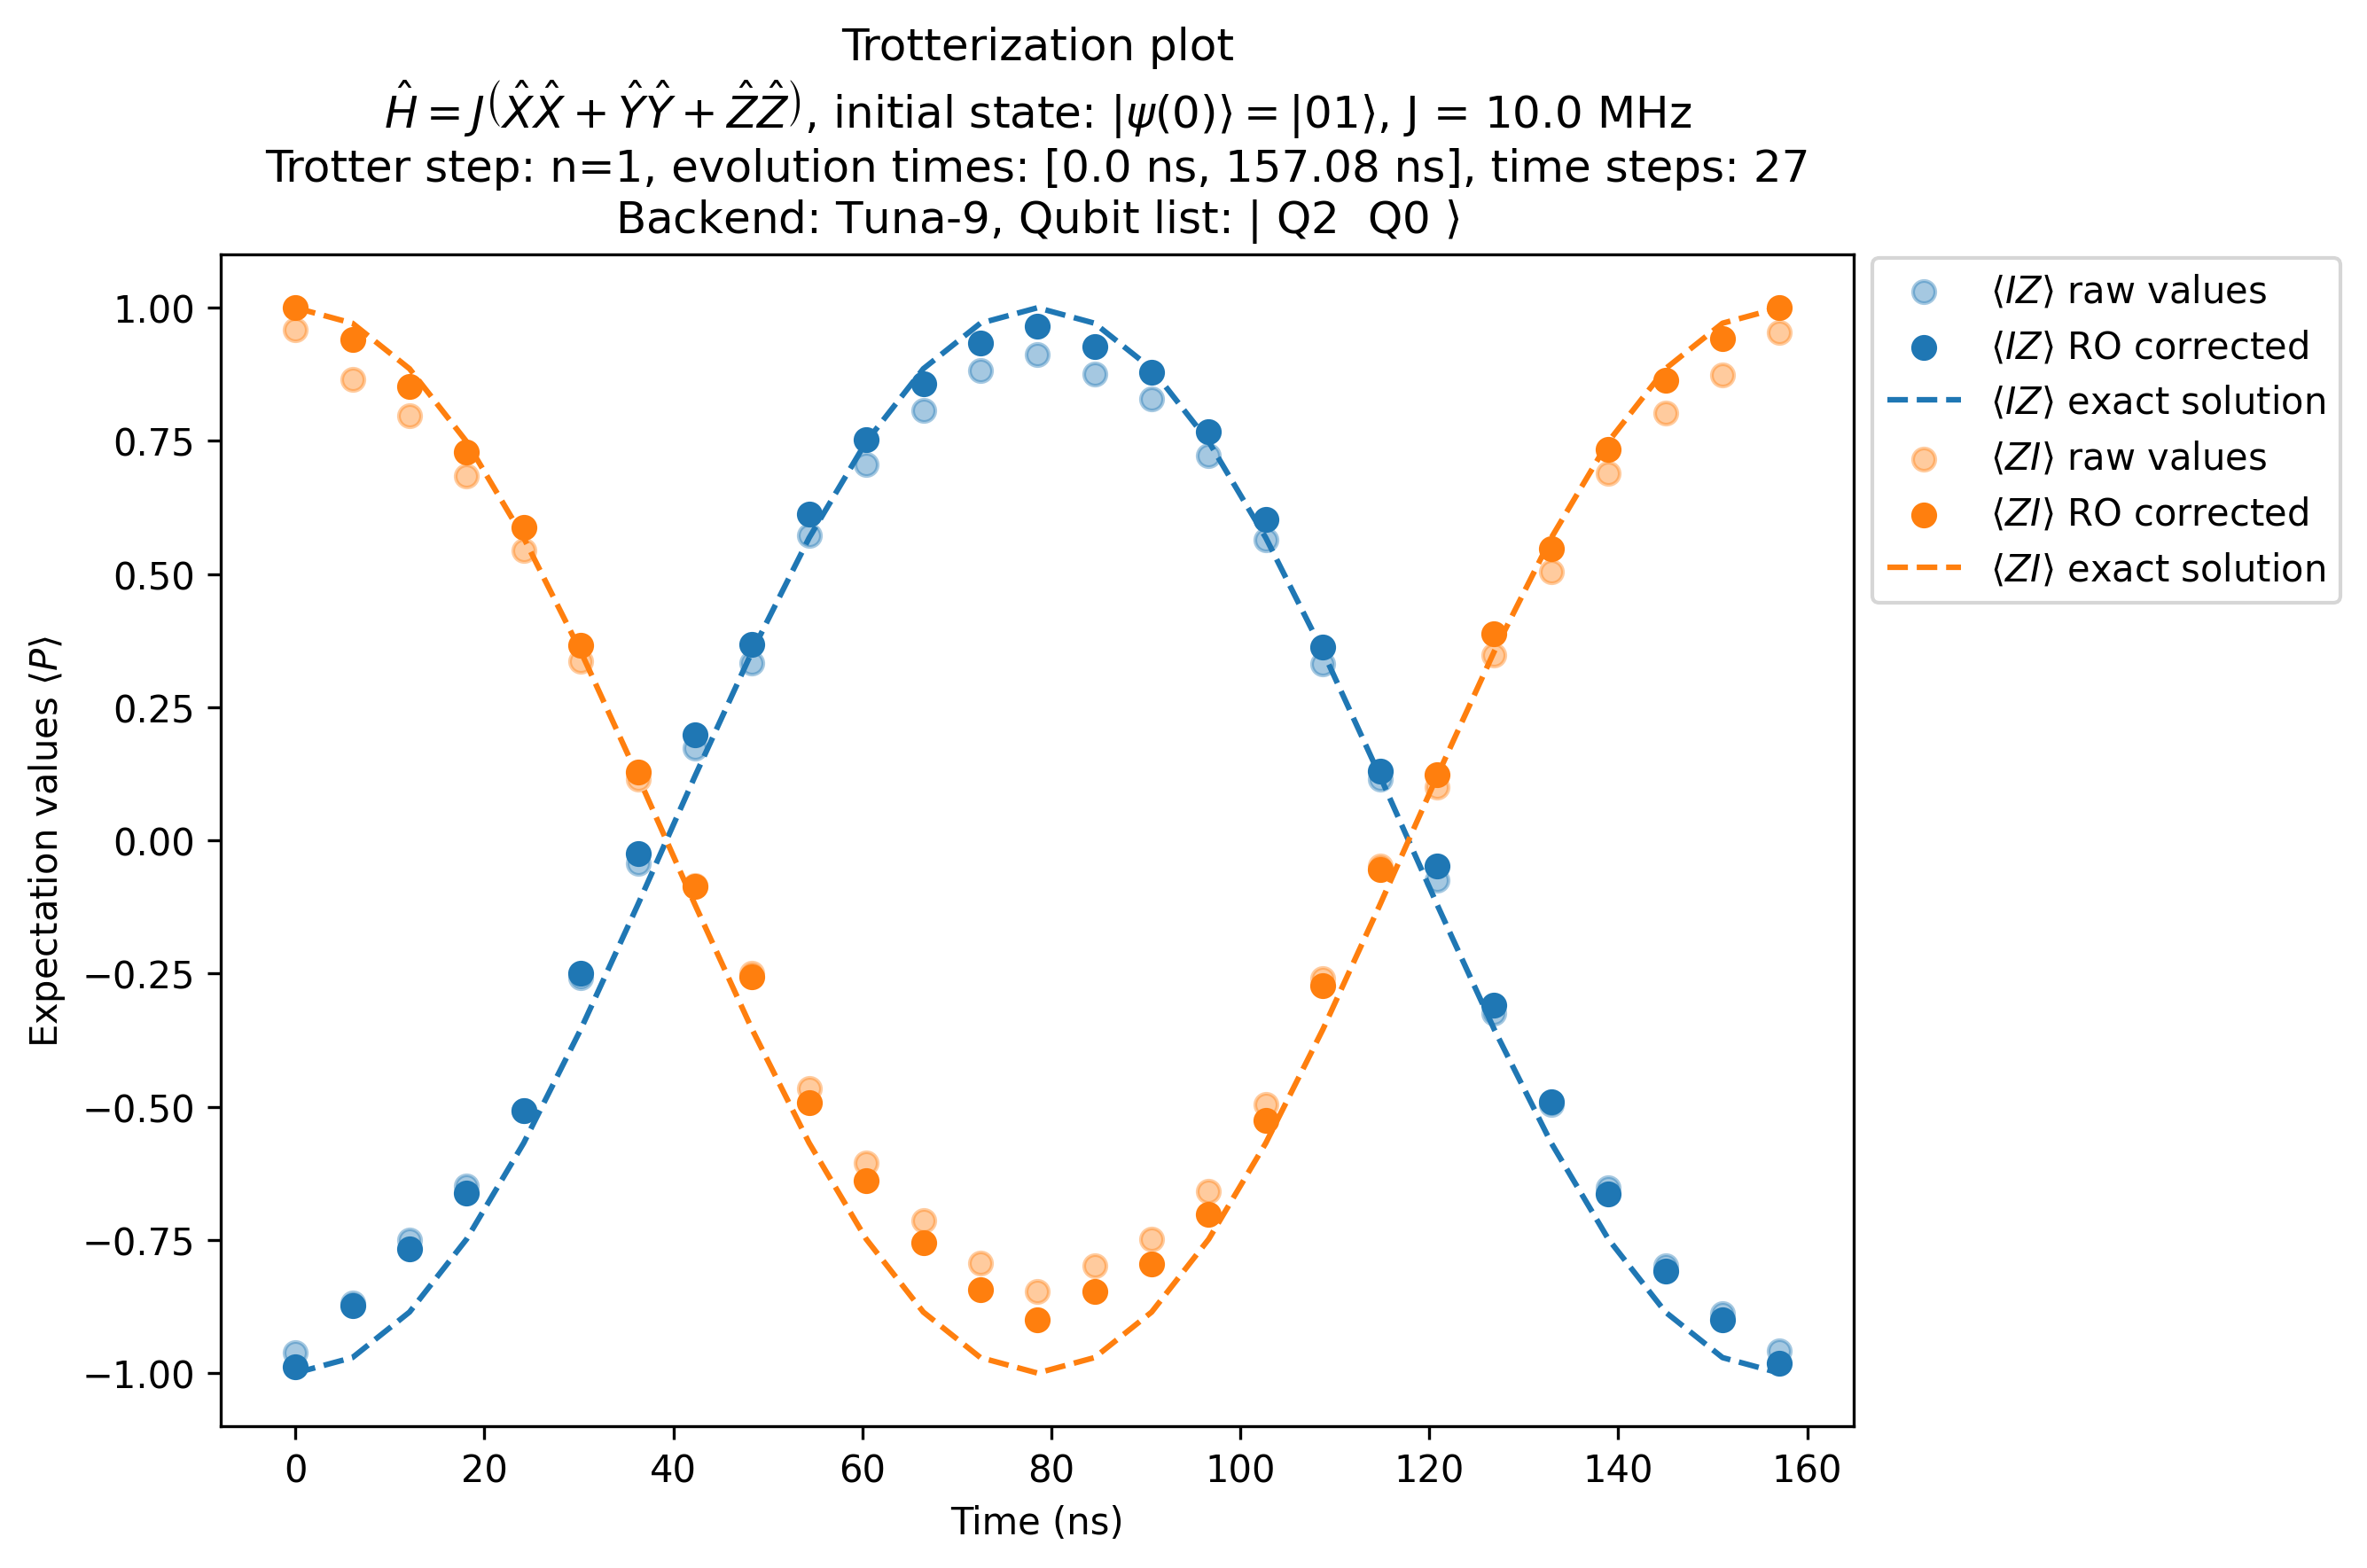

In [32]:
fig, ax = plt.subplots(figsize=(9, 6), dpi=300)

ax.scatter(evolution_times*1e9, IZ_values, label=r'$\langle IZ \rangle$ raw values', color='C0', alpha=0.4)
ax.scatter(evolution_times*1e9, IZ_values_ro_corrected, label=r'$\langle IZ \rangle$ RO corrected', color='C0')
ax.plot(evolution_times*1e9, observables['IZ']['values'], label=r'$\langle IZ \rangle$ exact solution', color='C0', linestyle='--')

ax.scatter(evolution_times*1e9, ZI_values, label=r'$\langle ZI \rangle$ raw values', color='C1', alpha=0.4)
ax.scatter(evolution_times*1e9, ZI_values_ro_corrected, label=r'$\langle ZI \rangle$ RO corrected', color='C1')
ax.plot(evolution_times*1e9, observables['ZI']['values'], label=r'$\langle ZI \rangle$ exact solution', color='C1', linestyle='--')

qubit_list_label = r"$|$"
for qubit_idx in qubit_list[::-1]:
   qubit_list_label += f" Q{qubit_idx} "
qubit_list_label += r"$\rangle$"
ax.set_xlabel('Time (ns)')
ax.set_ylabel(r'Expectation values $\langle P \rangle $')
ax.set_title('Trotterization plot\n' \
             r'$\hat{H} = J \left( \hat{X}\hat{X} + \hat{Y}\hat{Y} + \hat{Z}\hat{Z} \right)$, ' \
             r'initial state: $|\psi(0) \rangle = |$' f'{initial_state}' r'$\rangle$, ' r'J = ' f'{J/1e6} MHz' \
             f'\nTrotter step: n={trotter_order}, evolution times: [{np.round(evolution_times[0]*1e9, 2)} ns, ' \
                f'{np.round(evolution_times[-1]*1e9, 2)} ns], time steps: {len(evolution_times)}\n' \
             f'Backend: {result.backend_name}, Qubit list: {qubit_list_label}')

ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.85))

plt.tight_layout()
plt.show()